# [Paris Saclay Center for Data Science](http://www.datascience-paris-saclay.fr)

## [Fake News RAMP](http://www.ramp.studio/problems/fake_news): fake news detection

_Emanuela Boros (LIMSI), Balázs Kégl (LAL/CNRS)_

## Introduction
This is an initiation project to introduce RAMP and get you to know how it works.

The goal is to develop prediction models able to **identify which news is fake**. 

The data we will manipulate is from

### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0 
* pandas>=0.19.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)   
* seaborn>=0.7.1

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

## Exploratory data analysis

### Loading the data

matplotlib==2.0.2
plotly==2.1.0


In [5]:
train_filename = 'data/train.csv'
data = pd.read_csv(train_filename, sep='\t',
                       names=['city', 'date', 'party', 'source', 
                              'statement', 'title', 'truth'])
y_df = data['truth']
X_df = data.drop(['truth'], axis=1)
X_df.head()

,city,date,party,source,statement,title
2823,NaN,2015-12-30,NaN,Stephen Hayes,"Guantanamo has ""never been a key component of ...","A component, but an awfully small one"
2824,NaN,2015-12-30,NaN,Viral image,"Says U.S. Rep. Ted Yoho said ""African American...",A fake quote from a satirical news site
2825,Georgia,2015-12-30,None,State Public Service Announcement,"By the end of 2015, more than 1,300 people wil...","After nine years, traffic deaths rising"
2826,Florida,2015-12-29,Democrat,Patrick Murphy,"""91% of suspected terrorists who attempted to ...","The list isn't perfect, but data backs him up"
2827,Texas,2015-12-29,Republican,Ted Cruz,"""Existing law right now requires 700 miles of ...","""Existing law"" was changed in 2008"


In [6]:
data.describe()

,city,date,party,source,statement,title,truth
count,8604,11097,8604,11097,11097,11097,11097
unique,69,2491,20,2967,11082,10995,9
top,Florida,2010-10-28,Republican,Barack Obama,On changing the rules for filibusters on presi...,Not even close,Half-True
freq,1123,16,4341,586,3,8,2209


In [7]:
data.count()

city          8604
date         11097
party         8604
source       11097
statement    11097
title        11097
truth        11097
dtype: int64

The original training data frame has 11097 rows. In the starting kit, we give you a subset of 445 rows. Some passengers have missing information: in particular `city` and `party` info can be missing.

### Predicting survival

The goal is to predict whether a passenger has survived from other known attributes. Let us group the data according to the `Survived` columns:

In [13]:
data.groupby('truth').count()

,city,date,party,source,statement,title
truth,,,,,,
False,1575,2073,1575,2073,2073,2073
Full Flop,114,119,114,119,119,119
Half Flip,50,57,50,57,57,57
Half-True,1723,2209,1723,2209,2209,2209
Mostly False,1382,1794,1382,1794,1794,1794
Mostly True,1714,2092,1714,2092,2092,2092
No Flip,20,22,20,22,22,22
Pants on Fire!,542,905,542,905,905,905
True,1484,1826,1484,1826,1826,1826


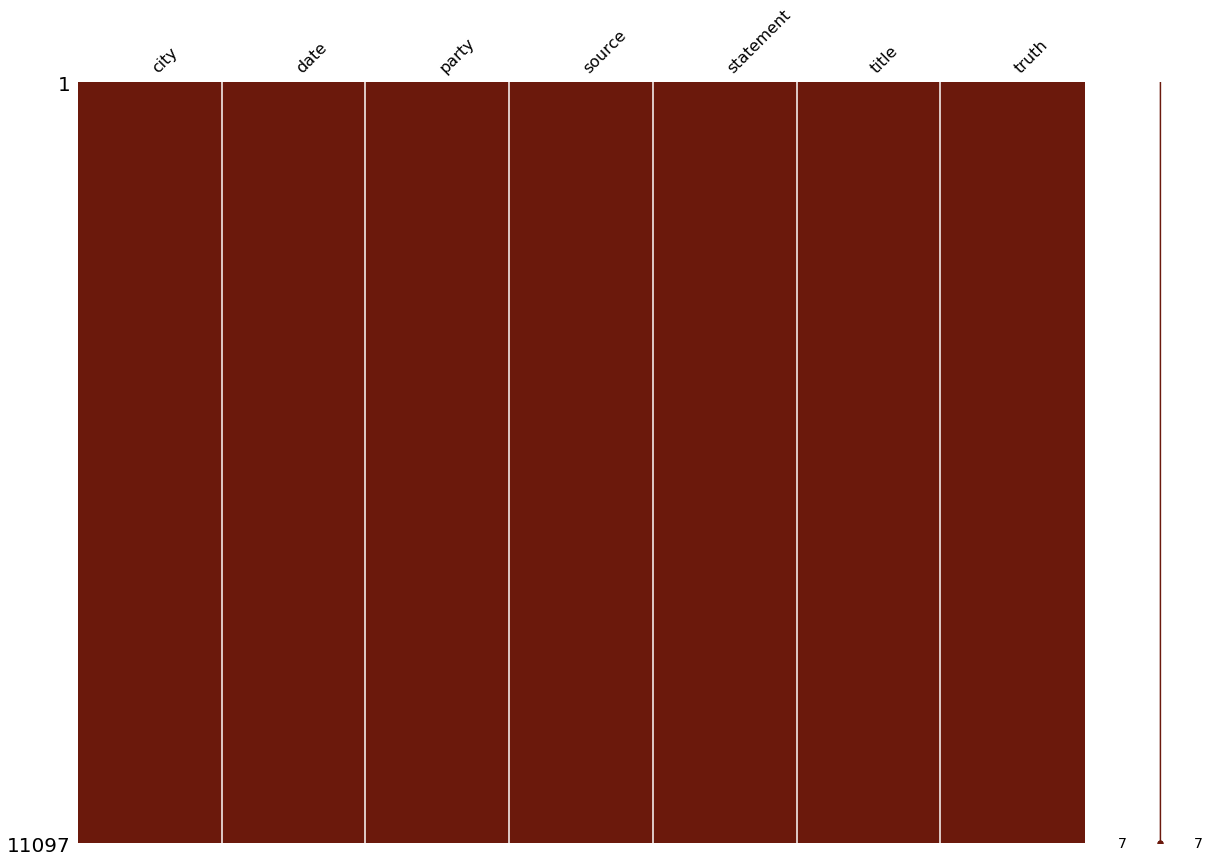

In [14]:
# Data Quality Check
import missingno as msno
msno.matrix(df=data, figsize=(20, 14), color=(0.42, 0.1, 0.05))


In [15]:
cols = train_copy.columns

feature_numbers = []

for col in cols:
    feature_numbers.append(len(data[col].unique()))
    

x, y = (list(x) for x in zip(*sorted(zip(feature_numbers , cols),reverse = True)))

trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Feature unique values',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature Unique Values',
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

In [17]:
data['city'] = data['city'].fillna(' ')
data['party'] = data['party'].fillna(' ')

## The pipeline

For submitting at the [RAMP site](http://ramp.studio), you will have to write two classes, saved in two different files:   
* the class `FeatureExtractor`, which will be used to extract features for classification from the dataset and produce a numpy array of size (number of samples $\times$ number of features). 
* a class `Classifier` to predict 

### Feature extractor

The feature extractor implements a `transform` member function. It is saved in the file [`submissions/starting_kit/feature_extractor.py`](/edit/submissions/starting_kit/feature_extractor.py). It receives the pandas dataframe `X_df` defined at the beginning of the notebook. It should produce a numpy array representing the extracted features, which will then be used for the classification.  

Note that the following code cells are *not* executed in the notebook. The notebook saves their contents in the file specified in the first line of the cell, so you can edit your submission before running the local test below and submitting it at the RAMP site.

### Classifier

The classifier follows a classical scikit-learn classifier template. It should be saved in the file [`submissions/starting_kit/classifier.py`](/edit/submissions/starting_kit/classifier.py). In its simplest form it takes a scikit-learn pipeline, assigns it to `self.clf` in `__init__`, then calls its `fit` and `predict_proba` functions in the corresponding member funtions.

In [18]:
%%file submissions/starting_kit/classifier.py


UsageError: %%file is a cell magic, but the cell body is empty.
